# Load my data set CIFAR-10 from hugging face .

In [1]:
#pip install -U datasets

In [2]:
from datasets import load_dataset
ds = load_dataset("uoft-cs/cifar10",split='train')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
ds.features

{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

In [4]:
ds[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

# process your data and get x_train and y_train

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [10]:
x_train = np.stack([np.array(images['img']) for images in ds]).astype('float32')
y_train  = np.array([labels['label'] for labels in ds]).astype('int8')

In [11]:
img_aug = ImageDataGenerator(
    rescale=1./255,                  # Normalize pixels to [0, 1]
    rotation_range=20,              # Random rotation ±15 degrees
    width_shift_range=0.15,          # Shift horizontally ±10%
    height_shift_range=0.15,         # Shift vertically ±10%
    shear_range=0.1,                # Apply shearing
    zoom_range=0.20,                 # Zoom in/out ±10%
    horizontal_flip=True,           # Random horizontal flip
    fill_mode='nearest'             # Fill new pixels after shift/rotation
)

In [12]:
#train this on my data now
train_generator = img_aug.flow(x_train,y_train, batch_size=64)

# build my module

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,GlobalMaxPooling2D,MaxPooling2D

In [28]:
#the architecture

Module = Sequential([
    #block1
    Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(32,32,3)),
    MaxPooling2D((2,2)), #16*16

    #block2
    Conv2D(64,(3,3),padding='same',activation='relu'),
    MaxPooling2D((2,2)), #8*8

    #FFN
    GlobalMaxPooling2D(),  #64 len
    Dense(64,activation='relu'),
    Dense(10,activation='softmax')


])

In [29]:
#show module summary
Module.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,202 (94.54 KB)

 Trainable params: 24,202 (94.54 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
#build module compiler
from tensorflow.keras.optimizers import AdamW

Module.compile(
    optimizer=AdamW(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# first fit process with non augmented data.

Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2187 - loss: 6.9070 - val_accuracy: 0.3934 - val_loss: 1.7349
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4029 - loss: 1.6693 - val_accuracy: 0.4420 - val_loss: 1.5636
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4543 - loss: 1.5186 - val_accuracy: 0.4992 - val_loss: 1.4057
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4912 - loss: 1.4163 - val_accuracy: 0.5040 - val_loss: 1.3793
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5202 - loss: 1.3433 - val_accuracy: 0.5086 - val_loss: 1.3977
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5260 - loss: 1.3083 - val_accuracy: 0.5190 - val_loss: 1.3462
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5508 - loss: 1.2532 - val_accuracy: 0.5050 - val_loss: 1.3789
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5580 - loss: 1.2361 - val_accuracy: 0.

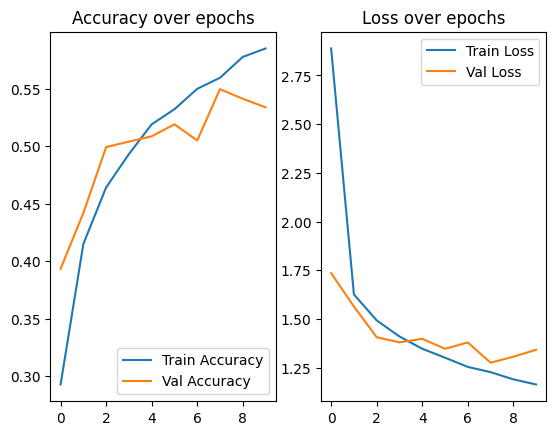

In [31]:
history=Module.fit(
    x_train,
    y_train,
    validation_split=.1,
    epochs=10,
    batch_size=64

)

#plot the fit results
# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over epochs')


# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# second fit process with non augmented data.

In [32]:
#load first data of validation or test
ds2 = load_dataset("uoft-cs/cifar10",split='test')
x_test = np.stack([np.array(images['img']) for images in ds2]).astype('float32')
y_test  = np.array([labels['label'] for labels in ds2]).astype('int8')

test_generator = img_aug.flow(x_test,y_test, batch_size=64)

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.1836 - loss: 2.1793 - val_accuracy: 0.3115 - val_loss: 1.8944
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.3199 - loss: 1.8750 - val_accuracy: 0.3581 - val_loss: 1.7592
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.3606 - loss: 1.7423 - val_accuracy: 0.3845 - val_loss: 1.6905
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.3884 - loss: 1.6647 - val_accuracy: 0.4099 - val_loss: 1.6081
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.4036 - loss: 1.6177 - val_accuracy: 0.4266 - val_loss: 1.5706
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.4219 - loss: 1.5789 - val_accuracy: 0.4311 - val_loss: 1.5597
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.4383 - loss: 1.5455 - val_accuracy: 0.4567 - val_loss: 1.5037
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.4538 - loss: 1.5123 - 

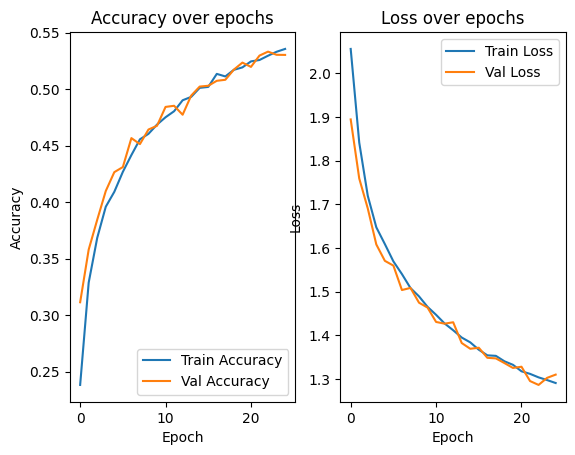

In [33]:
history2=Module.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,


)

#plot the fit results
# Accuracy
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [34]:
#Module.save('cifar10v1.keras')

# freeze some layers and fit module again with fouces on FFN part

In [43]:
# Freeze some layers
for i,layer in enumerate(Module.layers):
  layer.trainable=False
  if i==4:
    break

In [44]:
#change module compiler

Module.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.5437 - loss: 1.2700 - val_accuracy: 0.5415 - val_loss: 1.2771
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.5488 - loss: 1.2587 - val_accuracy: 0.5369 - val_loss: 1.2761
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.5499 - loss: 1.2539 - val_accuracy: 0.5433 - val_loss: 1.2730
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.5489 - loss: 1.2596 - val_accuracy: 0.5370 - val_loss: 1.2718
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - accuracy: 0.5502 - loss: 1.2550 - val_accuracy: 0.5444 - val_loss: 1.2664
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.5512 - loss: 1.2528 - val_accuracy: 0.5414 - val_loss: 1.2792
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.5480 - loss: 1.2552 - val_accuracy: 0.5385 - val_loss: 1.2769
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 48ms/step - accuracy: 0.5492 - loss: 1.2518 - 

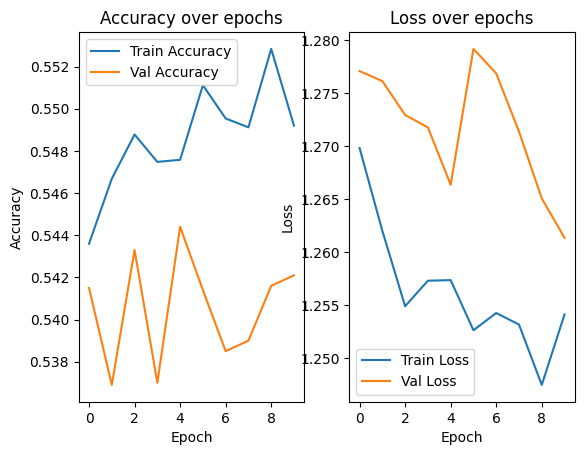

In [45]:
history3=Module.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,


)

#plot the fit results
# Accuracy
plt.subplot(1,2,1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



In [46]:
#Module.save('cifar10v2.keras')

# Test my module

In [61]:
from PIL import Image
from io import BytesIO
from tensorflow.keras.models import load_model
import requests
import pandas as pd

In [82]:
my_module= load_model('cifar10v1.keras')

In [53]:
my_class=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


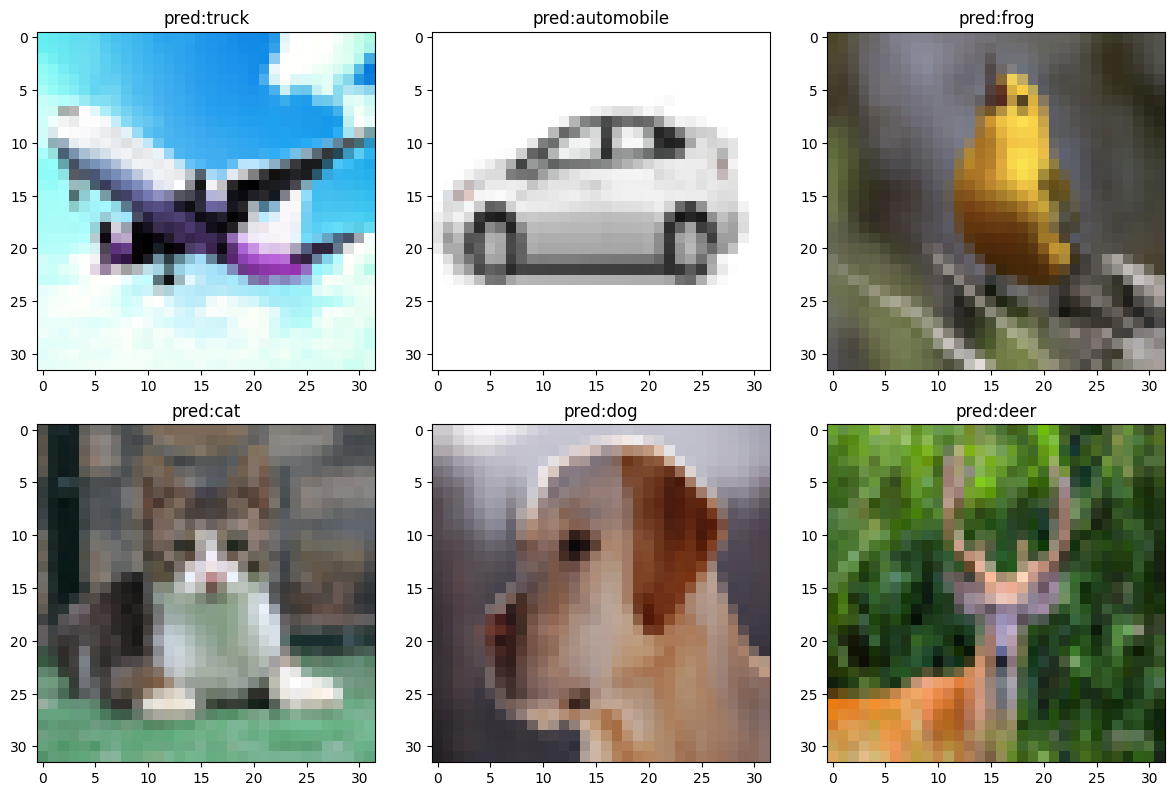

In [83]:
urls = pd.read_csv('test_urls.csv')
urls = urls['urls'].tolist()

preds=[]
imgs=[]
for i in range(7):
  data= requests.get(urls[i])
  img = Image.open(BytesIO(data.content))
  img = img.resize((32, 32))           # Resize to 32×32
  img_array = np.array(img) / 255.0    # Normalize to [0, 1]
  imgs.append(img_array)
  img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension: (1, 32, 32, 3)
  pred = my_module.predict(img_array)
  predicted_class = np.argmax(pred)
  preds.append(my_class[predicted_class])


fig, axis = plt.subplots(2,3,figsize=(12,8))

for i,ax in enumerate(axis.flat):
  ax.imshow(imgs[i])
  ax.set_title(f'pred:{preds[i]}')
plt.tight_layout()
plt.show()
